In [2]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage.color import label2rgb
import scipy 

from torch.utils.data import DataLoader
import torch.nn.functional as F

from gelgenie.segmentation.networks.UNets.model_gateway import smp_UNetPlusPlus
from gelgenie.segmentation.data_handling.dataloaders import ImageDataset

import torch
from scipy import ndimage as ndi
import pandas as pd

from os.path import join
import toml
from gelgenie.segmentation.networks import model_configure
from tqdm.notebook import tqdm as tqdm
from gelgenie.segmentation.evaluation.core_functions import model_predict_and_process
import ipywidgets as wdg 

In [48]:
g_file = '/Users/matt/Documents/PhD/research_output/Automatic_Gel_Analyzer/segmentation_results/unet++_august9_testing/gelanalyzer/ga_export_ladder_2.txt'

with open(g_file, 'r') as f:
    g_data = f.readlines()

key_data = []
update_key = False

naming = ['ga_ladder_1', 'ga_ladder_2', 'ga_ladder_3', 'ga_ladder_4', 'ga_ladder_1_bc', 'ga_ladder_2_bc', 'ga_ladder_3_bc', 'ga_ladder_4_bc']
inner_list = []

for line in g_data:
    if line.startswith('\n'):
        update_key = True
        continue
    if update_key:
        update_key = False
        key_data.append(inner_list)
        inner_list = []
    info = line.split('\t')
    inner_list.append(int(info[3]))
key_data.append(inner_list)
final_dict = {}
for name, data in zip(naming, key_data):
    final_dict[name] = data

df = pd.DataFrame.from_dict(final_dict)   

ref_data = [40, 40, 48, 40, 32, 120, 40, 57, 45, 122, 34, 31, 27, 23, 124, 49, 37, 32, 61]

# df['Reference Data'] = ref_data
# df.to_csv('/Users/matt/Desktop/ga_results.csv',index=False)

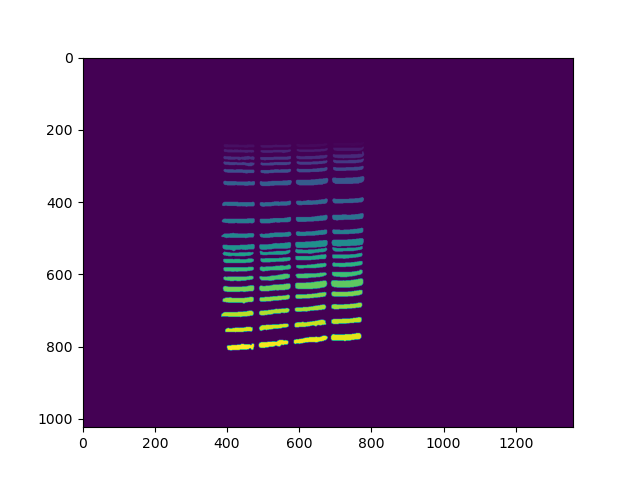

In [15]:
%matplotlib widget
seg_file = '/Users/matt/Documents/PhD/research_output/Automatic_Gel_Analyzer/segmentation_results/unet++_august9_testing/data/2_ladder_segmap.tif'
fig = plt.figure()
ladder_ids = []

def onclick(event):
    global colour_ids, glob_event
    ladder_ids.append(labelled_array[int(event.ydata), int(event.xdata)])
seg_array = np.array(Image.open(seg_file))
labelled_array,_ = ndi.label(seg_array)
plt.imshow(labelled_array)
ka = fig.canvas.mpl_connect('button_press_event', onclick)

(1024, 1360)

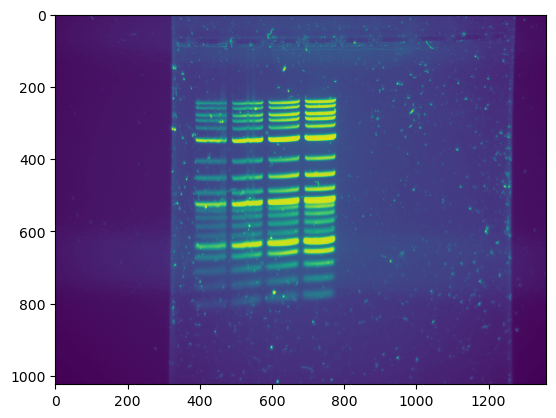

In [38]:
%matplotlib inline
orig_file = '/Users/matt/Documents/PhD/research_output/Automatic_Gel_Analyzer/segmentation_results/unet++_august9_testing/data/2_ladder.png'
orig_image = np.array(Image.open(orig_file))
plt.imshow(orig_image)
orig_image.shape

In [139]:
print(len(split_ids))
split_ids = [l for l in ladder_ids if l != 0] 

data_ids = []
final_data_ids = {}
for i in range(4):
    data_ids.append(split_ids[i*19:(i+1)*19])
background = 0.22048055

mask_im = np.ones_like(orig_image)

for index, name in enumerate(['seg_ladder_1', 'seg_ladder_2', 'seg_ladder_3', 'seg_ladder_4']):
    for label in data_ids[index]:
        mask_im[labelled_array == label] = 0

blacked_out_im = mask_im * orig_image

pixel_border = 20

for index, name in enumerate(['seg_ladder_1', 'seg_ladder_2', 'seg_ladder_3', 'seg_ladder_4']):
    band_sum = []
    band_sum_bc = []
    for label in data_ids[index]:
        pixel_count = len(orig_image[labelled_array == label])
        band_sum.append(np.sum(orig_image[labelled_array == label]))
        
        band_pos = np.nonzero(labelled_array == label)
        x_l, x_r = min(band_pos[1]), max(band_pos[1])
        y_t, y_b = min(band_pos[0]), max(band_pos[0])
        back_pixels = blacked_out_im[y_t-pixel_border:y_b+pixel_border, x_l-pixel_border:x_r+pixel_border]
        back_pixels = back_pixels[np.nonzero(back_pixels)]
        back_average = np.mean(back_pixels)
        
        band_sum_bc.append(np.sum(orig_image[labelled_array == label]) - (pixel_count*back_average))
    df[name] = band_sum
    df[name+'_bc'] = band_sum_bc
df['Reference Data'] = ref_data
df.to_csv('/Users/matt/Desktop/ladder_2_adaptive_background.csv',index=False)

76


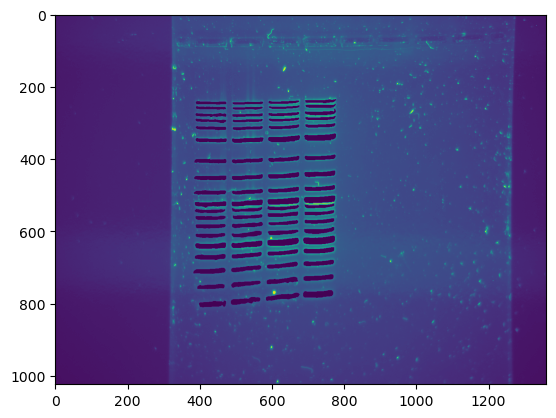

In [107]:
blacked_out_im = mask_im * orig_image
plt.imshow(blacked_out_im)

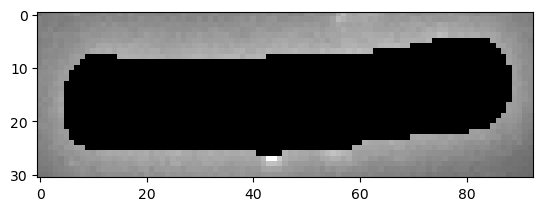

In [140]:
bsum = []
# mask_im = np.ones_like(orig_image)
pixel_border = 5

for index, name in enumerate(['seg_ladder_1', 'seg_ladder_2', 'seg_ladder_3', 'seg_ladder_4']):
    for label in data_ids[index]:
        # mask_im[labelled_array == label] = 0
        pixel_count = len(orig_image[labelled_array == label])
        bsum.append(np.sum(orig_image[labelled_array == label]))

        band_pos = np.nonzero(labelled_array == label)
        
        x_l, x_r = min(band_pos[1]), max(band_pos[1])
        y_t, y_b = min(band_pos[0]), max(band_pos[0])
        back_pixels = blacked_out_im[y_t-pixel_border:y_b+pixel_border, x_l-pixel_border:x_r+pixel_border]
        back_shot = blacked_out_im[y_t-pixel_border:y_b+pixel_border, x_l-pixel_border:x_r+pixel_border]
        back_pixels = back_pixels[np.nonzero(back_pixels)]
        back_average = np.mean(back_pixels)
plt.imshow(back_shot,cmap='gray')
pass

In [162]:
smdata = orig_image[labelled_array == data_ids[0][0]]

In [ ]:
minx = 74
maxx = 171



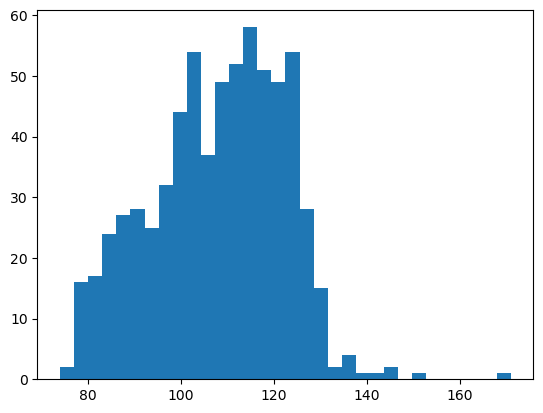

In [167]:
plt.hist(smdata,bins=32)
pass

In [151]:
data_ids

[[3, 7, 11, 15, 19, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 68, 72, 76],
 [4, 8, 12, 16, 20, 23, 27, 31, 35, 39, 43, 47, 51, 55, 59, 63, 67, 71, 75],
 [2, 6, 10, 14, 18, 22, 26, 30, 34, 38, 42, 46, 50, 54, 58, 62, 66, 70, 74],
 [1, 5, 9, 13, 17, 21, 25, 29, 33, 37, 41, 45, 49, 53, 57, 61, 65, 69, 73]]

In [149]:

max(np.nonzero(labelled_array == label)[1])

770

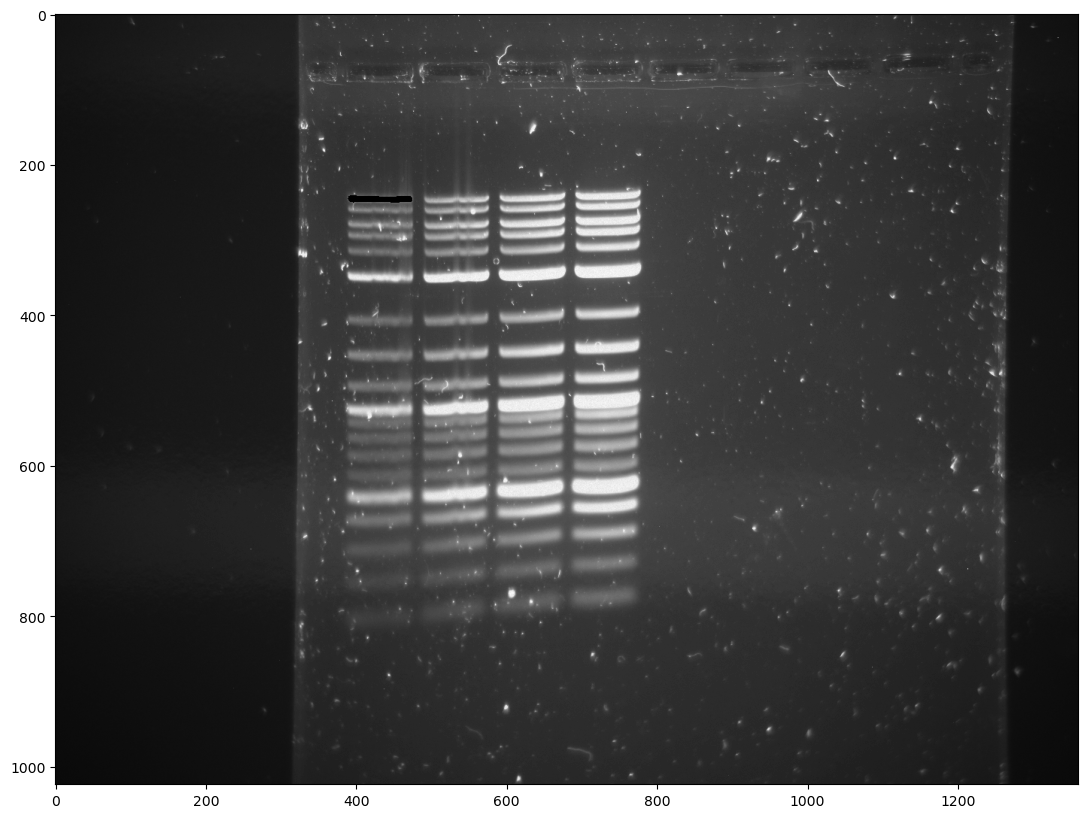

In [155]:
%matplotlib inline
import copy

colored_image = copy.copy(orig_image)
colored_image[np.nonzero(labelled_array == data_ids[0][0])] = 0

plt.figure(figsize=(15,10))
plt.imshow(colored_image,cmap='gray')


In [65]:
band_sum_bc

[98865.7767445,
 98394.880859,
 123028.72236175,
 100062.88944575,
 96797.64686975,
 206270.7674425,
 113404.68229025,
 156484.06440124998,
 127471.789267,
 220743.18676274997,
 83848.55420424999,
 78625.077639,
 78599.82647624999,
 72251.66797899999,
 241388.352058,
 149310.86762124998,
 91080.43971425001,
 48430.42254075,
 43557.32522425]

In [148]:

data_dict = {}
for index, name in enumerate(['ladder_1', 'ladder_2', 'ladder_3', 'ladder_4']):
    data_dict[name] = data_ids[index]
    
dids_df = pd.DataFrame.from_dict(data_dict)
dids_df.to_csv('/Users/matt/Desktop/segmentation_ids.csv',index=False)

In [147]:
dids_df

,ladder_1,ladder_2,ladder_3,ladder_4
0,3,4,2,1
1,7,8,6,5
2,11,12,10,9
3,15,16,14,13
4,19,20,18,17
5,24,23,22,21
6,28,27,26,25
7,32,31,30,29
8,36,35,34,33
9,40,39,38,37


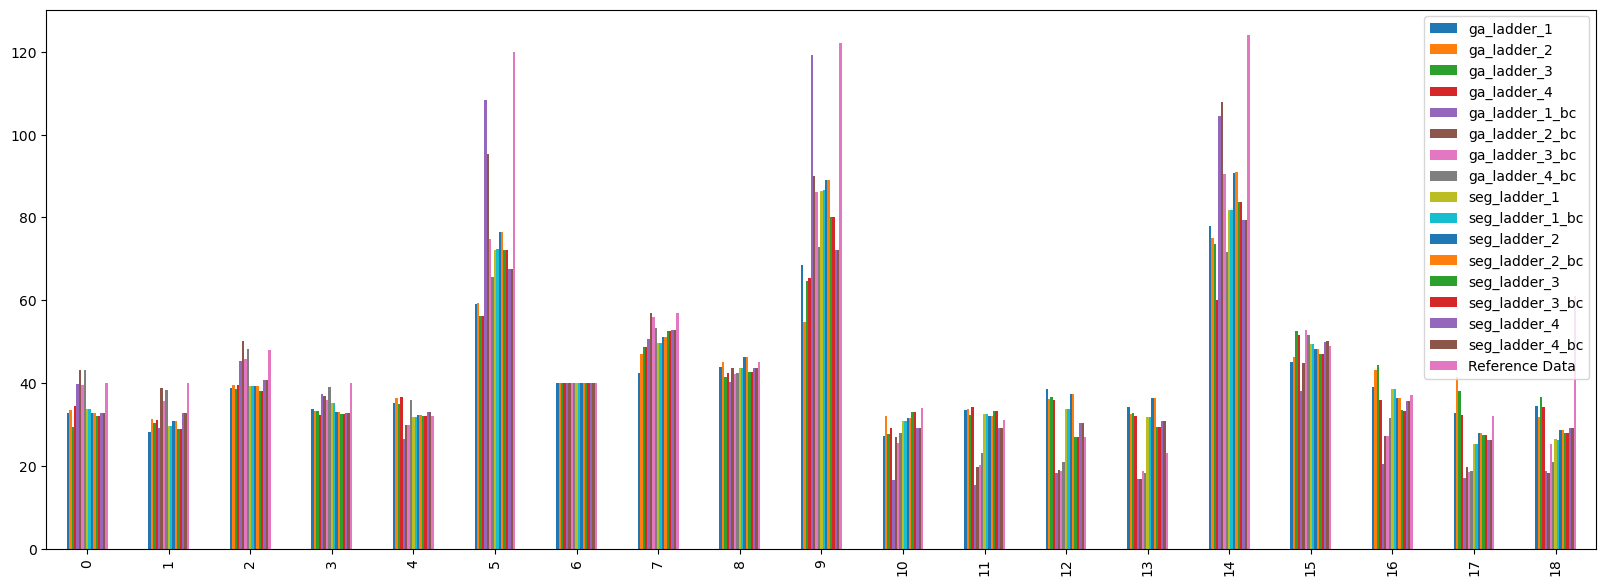

In [51]:
%matplotlib inline
ref_pos = 6
fig, ax = plt.subplots(figsize=(20,7))
df.divide(df.iloc[ref_pos]).multiply(ref_data[ref_pos]).plot.bar(ax=ax)
pass

In [5]:

model_folder = '/Users/matt/Documents/PhD/research_output/Automatic_Gel_Analyzer/segmentation_models'
model_name = 'smp_unet++_july28_1'
ref_data_folder = '/Users/matt/Documents/PhD/research_output/Automatic_Gel_Analyzer/segmentation_results/unet++_august9_testing/data'
epoch = 306

exp_folder = join(model_folder, model_name)
model_config = toml.load(join(exp_folder, 'config.toml'))['model']

model, _, _ = model_configure(**model_config)

checkpoint = torch.load(f=join(exp_folder, 'checkpoints', 'checkpoint_epoch_%s.pth' % epoch),
                        map_location=torch.device("cpu"))

model.load_state_dict(checkpoint['network'])
model.eval()
dataset = ImageDataset(ref_data_folder, 1, padding=True)
dataloader = DataLoader(dataset, shuffle=False, batch_size=1, num_workers=0, pin_memory=True)

easy_image = '2_ladder'
hard_image = '3_ladder'

# preparing model outputs, including separation of different bands and labelling
for im_index, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
    if batch['image_name'][0] == easy_image:
        e_im = batch['image'].detach().squeeze().cpu().numpy()
        _, e_mask = model_predict_and_process(model, batch['image'])
        e_labels, _ = ndi.label(e_mask.argmax(axis=0))
        e_direct_labels = label2rgb(e_labels, image=e_im)
    elif batch['image_name'][0] == hard_image:
        h_im = batch['image'].detach().squeeze().cpu().numpy()
        _, h_mask = model_predict_and_process(model, batch['image'])
        h_labels, _ = ndi.label(h_mask.argmax(axis=0))
        h_direct_labels = label2rgb(h_labels, image=h_im)


Padding images to 1376x1376

Created dataset with 2 images.

  0%|          | 0/2 [00:00<?, ?it/s]

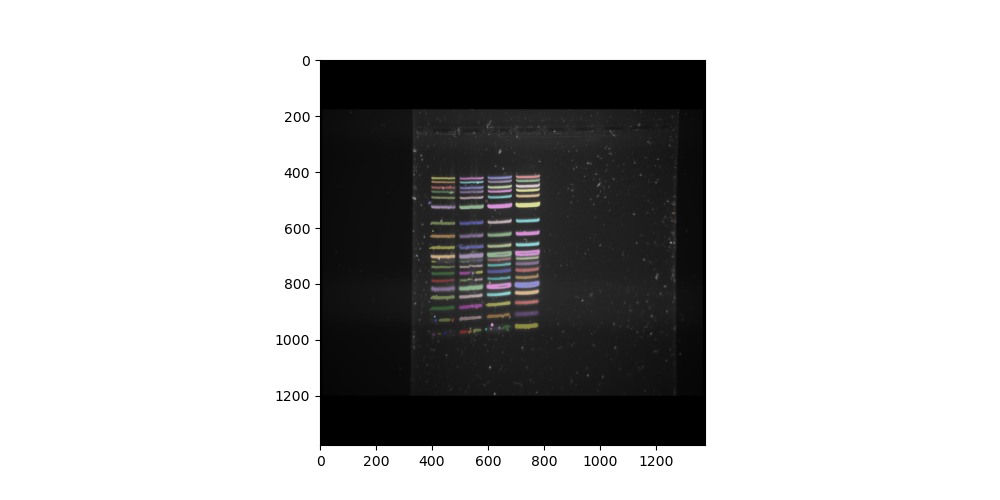

In [8]:
plt.figure(figsize=(10,5))
plt.imshow(e_direct_labels)

In [186]:

band_sum = []
band_sum_bc = []
for b_id in [1,5,9,17,13,23,28,34,38]:
    pixel_count = len(e_im[e_labels == b_id])
    band_sum.append(np.sum(e_im[e_labels == b_id]))
    band_sum_bc.append(np.sum(e_im[e_labels == b_id]) - (pixel_count*background))
band_sum.extend([0] * 10)
band_sum_bc.extend([0] * 10)

band_sum

[509.0039,
 443.40393,
 571.902,
 537.4275,
 508.6667,
 1065.3804,
 606.702,
 807.4471,
 655.1294,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [182]:
len(e_im[890:960,397:468])

70

In [181]:
%matplotlib inline

background = np.average(e_im[890:960,397:468])
background

0.22048055

In [177]:
e_im[e_labels == 23]

array([0.5803922 , 0.57254905, 0.5921569 , ..., 0.7372549 , 0.7254902 ,
       0.72156864], dtype=float32)

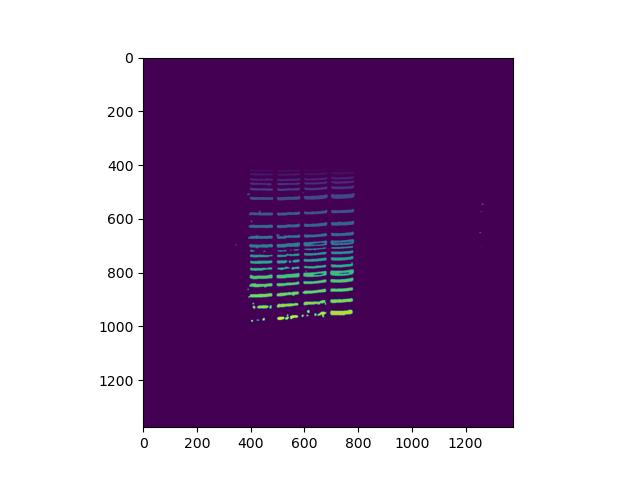

In [163]:
%matplotlib widget
colour_ids = []
fig = plt.figure()
plt.imshow(e_labels)

glob_event = None

# Define a callback function that will update the textarea
def onclick(event):
    global colour_ids, glob_event
    colour_ids.append((int(event.xdata), int(event.ydata)))
    print(event.x, event.y)
    glob_event = event

ka = fig.canvas.mpl_connect('button_press_event', onclick)



In [156]:
for location in colour_ids:
    sel_colour = e_labels[location[1], location[0]]

In [160]:
np.where(e_labels == sel_colour)

(array([678, 678, 678, ..., 699, 699, 699]),
 array([775, 776, 777, ..., 721, 722, 723]))

In [161]:
masked_im = np.zeros_like(e_direct_labels)
masked_im[np.where(e_labels == sel_colour)] = [1,0,1]
# masked_im[np.where(np.all(e_direct_labels == sel_colour, axis=-1))] = [1,0,1]

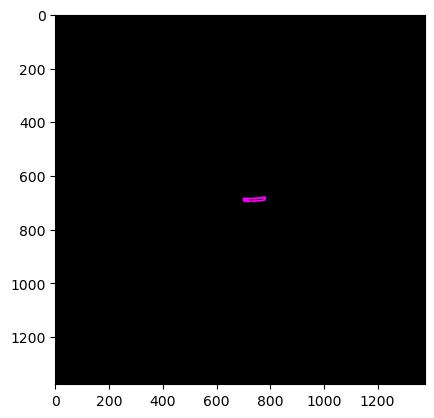

In [162]:
%matplotlib inline
plt.figure()
plt.imshow(masked_im)

In [78]:
masked_im.shape

(1376, 1376, 3)

In [38]:
sel_colour

array([0.06313726, 0.06313726, 0.06313726])

In [40]:
e_direct_labels == sel_colour

array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False,

In [41]:
e_direct_labels.shape

(1376, 1376, 3)

In [63]:
tst_array = np.zeros((4,4,3))

tst_array[2,2,:] = [0.06313726, 0.06313726, 0.06313726]
tst_array[3,3,:] = [0.06313726, 0.06313726, 0.06313726]

sel_colour =  [0.06313726, 0.06313726, 0.06313726]
tst_array == sel_colour
tst_array[np.where(np.all(tst_array == sel_colour, axis=-1))]

array([[0.06313726, 0.06313726, 0.06313726],
       [0.06313726, 0.06313726, 0.06313726]])

In [53]:
indices

(array([], dtype=int64), array([], dtype=int64))

In [54]:
tst_array

array([[[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.06313726, 0.06313726, 0.06313726],
        [0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]]])

In [55]:
sel_colour

array([0.06313726, 0.06313726, 0.06313726])